# Estimating Binary Factor Analysis
One of the simplest model for generative auto-encoders is Factor Analysis. We'll use our method to learn it, with the loss function


$$ \mathcal L(\boldsymbol \theta, y^{(i)})  = {y^{(i)}}^\top \hat y_{\boldsymbol \theta}^{(i)} - \mathbb E_{p_{\boldsymbol\theta}}[y^\top \hat y_{\boldsymbol \theta}]$$

where $\hat y_{\boldsymbol \theta} = \text{decoder}_{\boldsymbol \theta}(\text{encoder}_{\boldsymbol \theta}(y))$ and $y\sim p_{\boldsymbol \theta}$.

The encoder and decoder are optimized separately

In [50]:
import torch
from torch import nn
import numpy as np
import math
import matplotlib.pyplot as plt
import copy


from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [51]:
# DIMENSIONS
n = 20
p = 1000
q = 1
DIMENSION_Y = (n, p)
DIMENSION_Z = (n, q)

In [52]:
class FA(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize Module
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.encoder_opt = torch.optim.Adam(self.encoder.parameters())

    def forward(self, y):
        with torch.no_grad():
            z = self.encoder(y)
        y = self.decoder(z)
        return y
    
    def sample(self, z = None):
        """Sample from the fitted model."""
        with torch.no_grad():
            if z is None:
                z = torch.randn(DIMENSION_Z)
            probs = self.decoder(z)
            y = torch.bernoulli(probs)
        return (y, z)

    def encoder_fit(self, y, z, epochs=100, verbose=False):
        encoder_loss = nn.MSELoss()
        for epoch in range(epochs):
            self.encoder_opt.zero_grad()

            zhat = self.encoder(y)
            loss = encoder_loss(zhat, z)
            loss.backward()
            self.encoder_opt.step()

            if verbose:
                print("Epoch {} Loss {:.2f}".format(epoch, loss.item()))
        return loss.item()

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Define parameters
        self.w = nn.Parameter(torch.randn(q, p))
        self.b = nn.Parameter(torch.zeros(p))
    
    # override forward
    def forward(self, z):
        linpar = z @ self.w + self.b
        probs = 1/(1+torch.exp(-linpar)) 
        return probs


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Define a sequential model
        self.encoder_model = nn.Sequential(
            nn.Linear(in_features = p, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features = 100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = q)
        )

    def forward(self, y):
        return self.encoder_model(y)

class GMLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target, input_sim, target_sim):
        loss = - torch.mean(input * target - input_sim * target_sim)
        return loss

In [53]:
model_true = FA()
y_true, z_true = model_true.sample()
assert y_true.shape == DIMENSION_Y and z_true.shape == DIMENSION_Z
model = FA()
loss_fn = GMLoss()
# Fit the model
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=0.1)
# Fit eval: MSE
eval_fn = nn.MSELoss()


In [54]:
for epoch in range(1000):
    # Simulate and forward pass on the simulated sample
    y_sim, z_sim = model.sample()

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    target_true = model(y_true)
    target_sim = model(y_sim)

    # Compute the loss
    loss = loss_fn(y_true, target_true, y_sim, target_sim)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        eval = eval_fn(y_true, target_true).item()
    
    # Train the encoder (this is done here so as not to have dependence with the encoder and the generate data used for the decoder)
    loss_encoder = model.encoder_fit(y_sim, z_sim, epochs=1, verbose=False)
    writer.add_scalar("Loss Decoder", eval, epoch)
    writer.add_scalar("Loss encoder", loss_encoder, epoch)

    # Eval the fit every 10 epochs
    if epoch % 10 == 0:
        print("Epoch {} Loss: decoder {:.3f}, encoder {:.3f}".format(epoch, eval, loss_encoder))

Epoch 0 Loss: decoder 0.251, encoder 0.854
Epoch 10 Loss: decoder 0.241, encoder 0.109
Epoch 20 Loss: decoder 0.243, encoder 0.297
Epoch 30 Loss: decoder 0.240, encoder 0.371
Epoch 40 Loss: decoder 0.266, encoder 0.227
Epoch 50 Loss: decoder 0.264, encoder 0.293
Epoch 60 Loss: decoder 0.252, encoder 0.232
Epoch 70 Loss: decoder 0.240, encoder 0.115
Epoch 80 Loss: decoder 0.230, encoder 0.048
Epoch 90 Loss: decoder 0.226, encoder 0.090
Epoch 100 Loss: decoder 0.225, encoder 0.091
Epoch 110 Loss: decoder 0.226, encoder 0.117
Epoch 120 Loss: decoder 0.221, encoder 0.052
Epoch 130 Loss: decoder 0.219, encoder 0.028
Epoch 140 Loss: decoder 0.218, encoder 0.051
Epoch 150 Loss: decoder 0.217, encoder 0.050
Epoch 160 Loss: decoder 0.216, encoder 0.060
Epoch 170 Loss: decoder 0.215, encoder 0.027
Epoch 180 Loss: decoder 0.215, encoder 0.029
Epoch 190 Loss: decoder 0.215, encoder 0.060
Epoch 200 Loss: decoder 0.214, encoder 0.028
Epoch 210 Loss: decoder 0.214, encoder 0.025
Epoch 220 Loss: decod

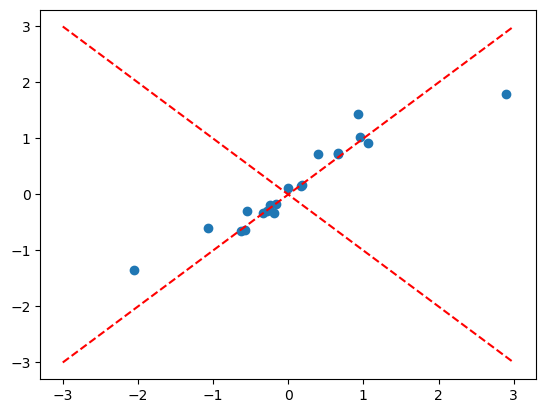

In [55]:
plt.scatter(model.encoder(y_true).detach().numpy(), z_true.detach().numpy())
plt.plot([-3,3], [3,-3], "--", color = "red")
plt.plot([-3,3], [-3,3], "--", color = "red")

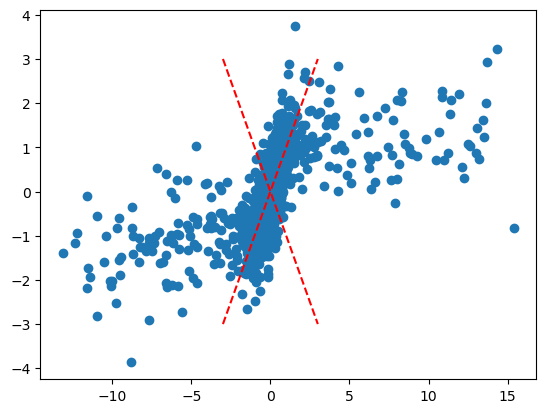

In [56]:
plt.scatter(list(model.decoder.parameters())[0].detach().numpy(), list(model_true.decoder.parameters())[0].detach().numpy())
plt.plot([-3,3], [3,-3], "--", color = "red")
plt.plot([-3,3], [-3,3], "--", color = "red")